In [1]:
import random
from copy import deepcopy
from math import log10

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.axes import Axes

In [2]:
def stake_transformation(values, slope, curvature, threshold):
    transformed_stakes = []

    for x in values:
        if x <= 30e3:
            transformed_stakes.append(0.0001)
        elif x <= threshold:
            f_x = slope * x
            transformed_stakes.append(f_x)
        else:
            g_x = slope * threshold + (x - threshold) ** (1 / curvature)
            transformed_stakes.append(g_x)

    return transformed_stakes

def compute_probabilities(stakes: list):
    sum_stakes = sum(stakes)
    return [s / sum_stakes for s in stakes]

def compute_rewards(probabilities: list, budget: int):
    return [p * budget for p in probabilities]

def compute_apy(opt: dict, data: list, percentage: bool = False):
    transformed_stakes = stake_transformation(data, **opt["model_arguments"])

    probabilities = compute_probabilities(transformed_stakes)

    rewards = compute_rewards(probabilities, opt["budget"])

    period_apy = [r / s for r, s in zip(rewards, transformed_stakes)]
    yearly_apy = [apy * 12 / opt["period_in_months"] for apy in period_apy]
    
    apy = sum(yearly_apy) / len(yearly_apy)

    if percentage:
        return apy * 100
    
    return apy

def factor_and_prefix(value):
    factor = int(int(log10(value))/3)*3
    if factor < 3:
        prefix = ""
    elif factor < 6:
        prefix = "k"
    elif factor < 9:
        prefix = "M"

    return 10**factor, prefix


def probabilistic_apy(datas: list[list], options: list[dict], steps:int = 100):
    result_template = {"apys": [], "average": 0}

    results = [deepcopy(result_template) for _ in range(len(options))]

    for idx, opt in enumerate(options):
        for _ in range(steps):
            stakes = sum([random.sample(data, count) for data, count in zip(datas, opt["data_count"])], [])

            tf_stakes = stake_transformation(stakes, **opt["model_arguments"])
            
            apy = compute_apy(opt, tf_stakes, percentage=False)

            results[idx]["apys"].append(apy)

        results[idx]["average"] = np.mean(results[idx]["apys"])
        results[idx]["std"] = np.std(results[idx]["apys"])

    return results


In [3]:
raw_all = pd.read_csv("all_01H7Z22K1VRTXCWJJJFV2A64VP.csv", low_memory=False)
raw_nft = pd.read_csv("nft_01H7Z2W99SMWJ01YN552WSRADV.csv", low_memory=False)

raw_data = pd.merge(raw_all, raw_nft, on="account", how="left")

condition = raw_data["token_id"].isnull()

staking_info_nft_holders = list(raw_data[~condition]["actual_stake"])
staking_info_non_nft_holders = list(raw_data[condition]["actual_stake"])
staking_info_all = list(raw_data["actual_stake"])

### Economic model

In [4]:
datas = [staking_info_nft_holders, staking_info_non_nft_holders, [500_000]]

options = [{
    "data_count": [200, 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "legend": "NR NFT holder"
},
{
    "data_count": [200, 200, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "legend": "everyone"
},
{
    "data_count": [200, 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "legend": "NR NFT holder + 500k whale"
},
{
    "data_count": [200, 200, 1],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "legend": "everyone  + 500k whale"
},
]

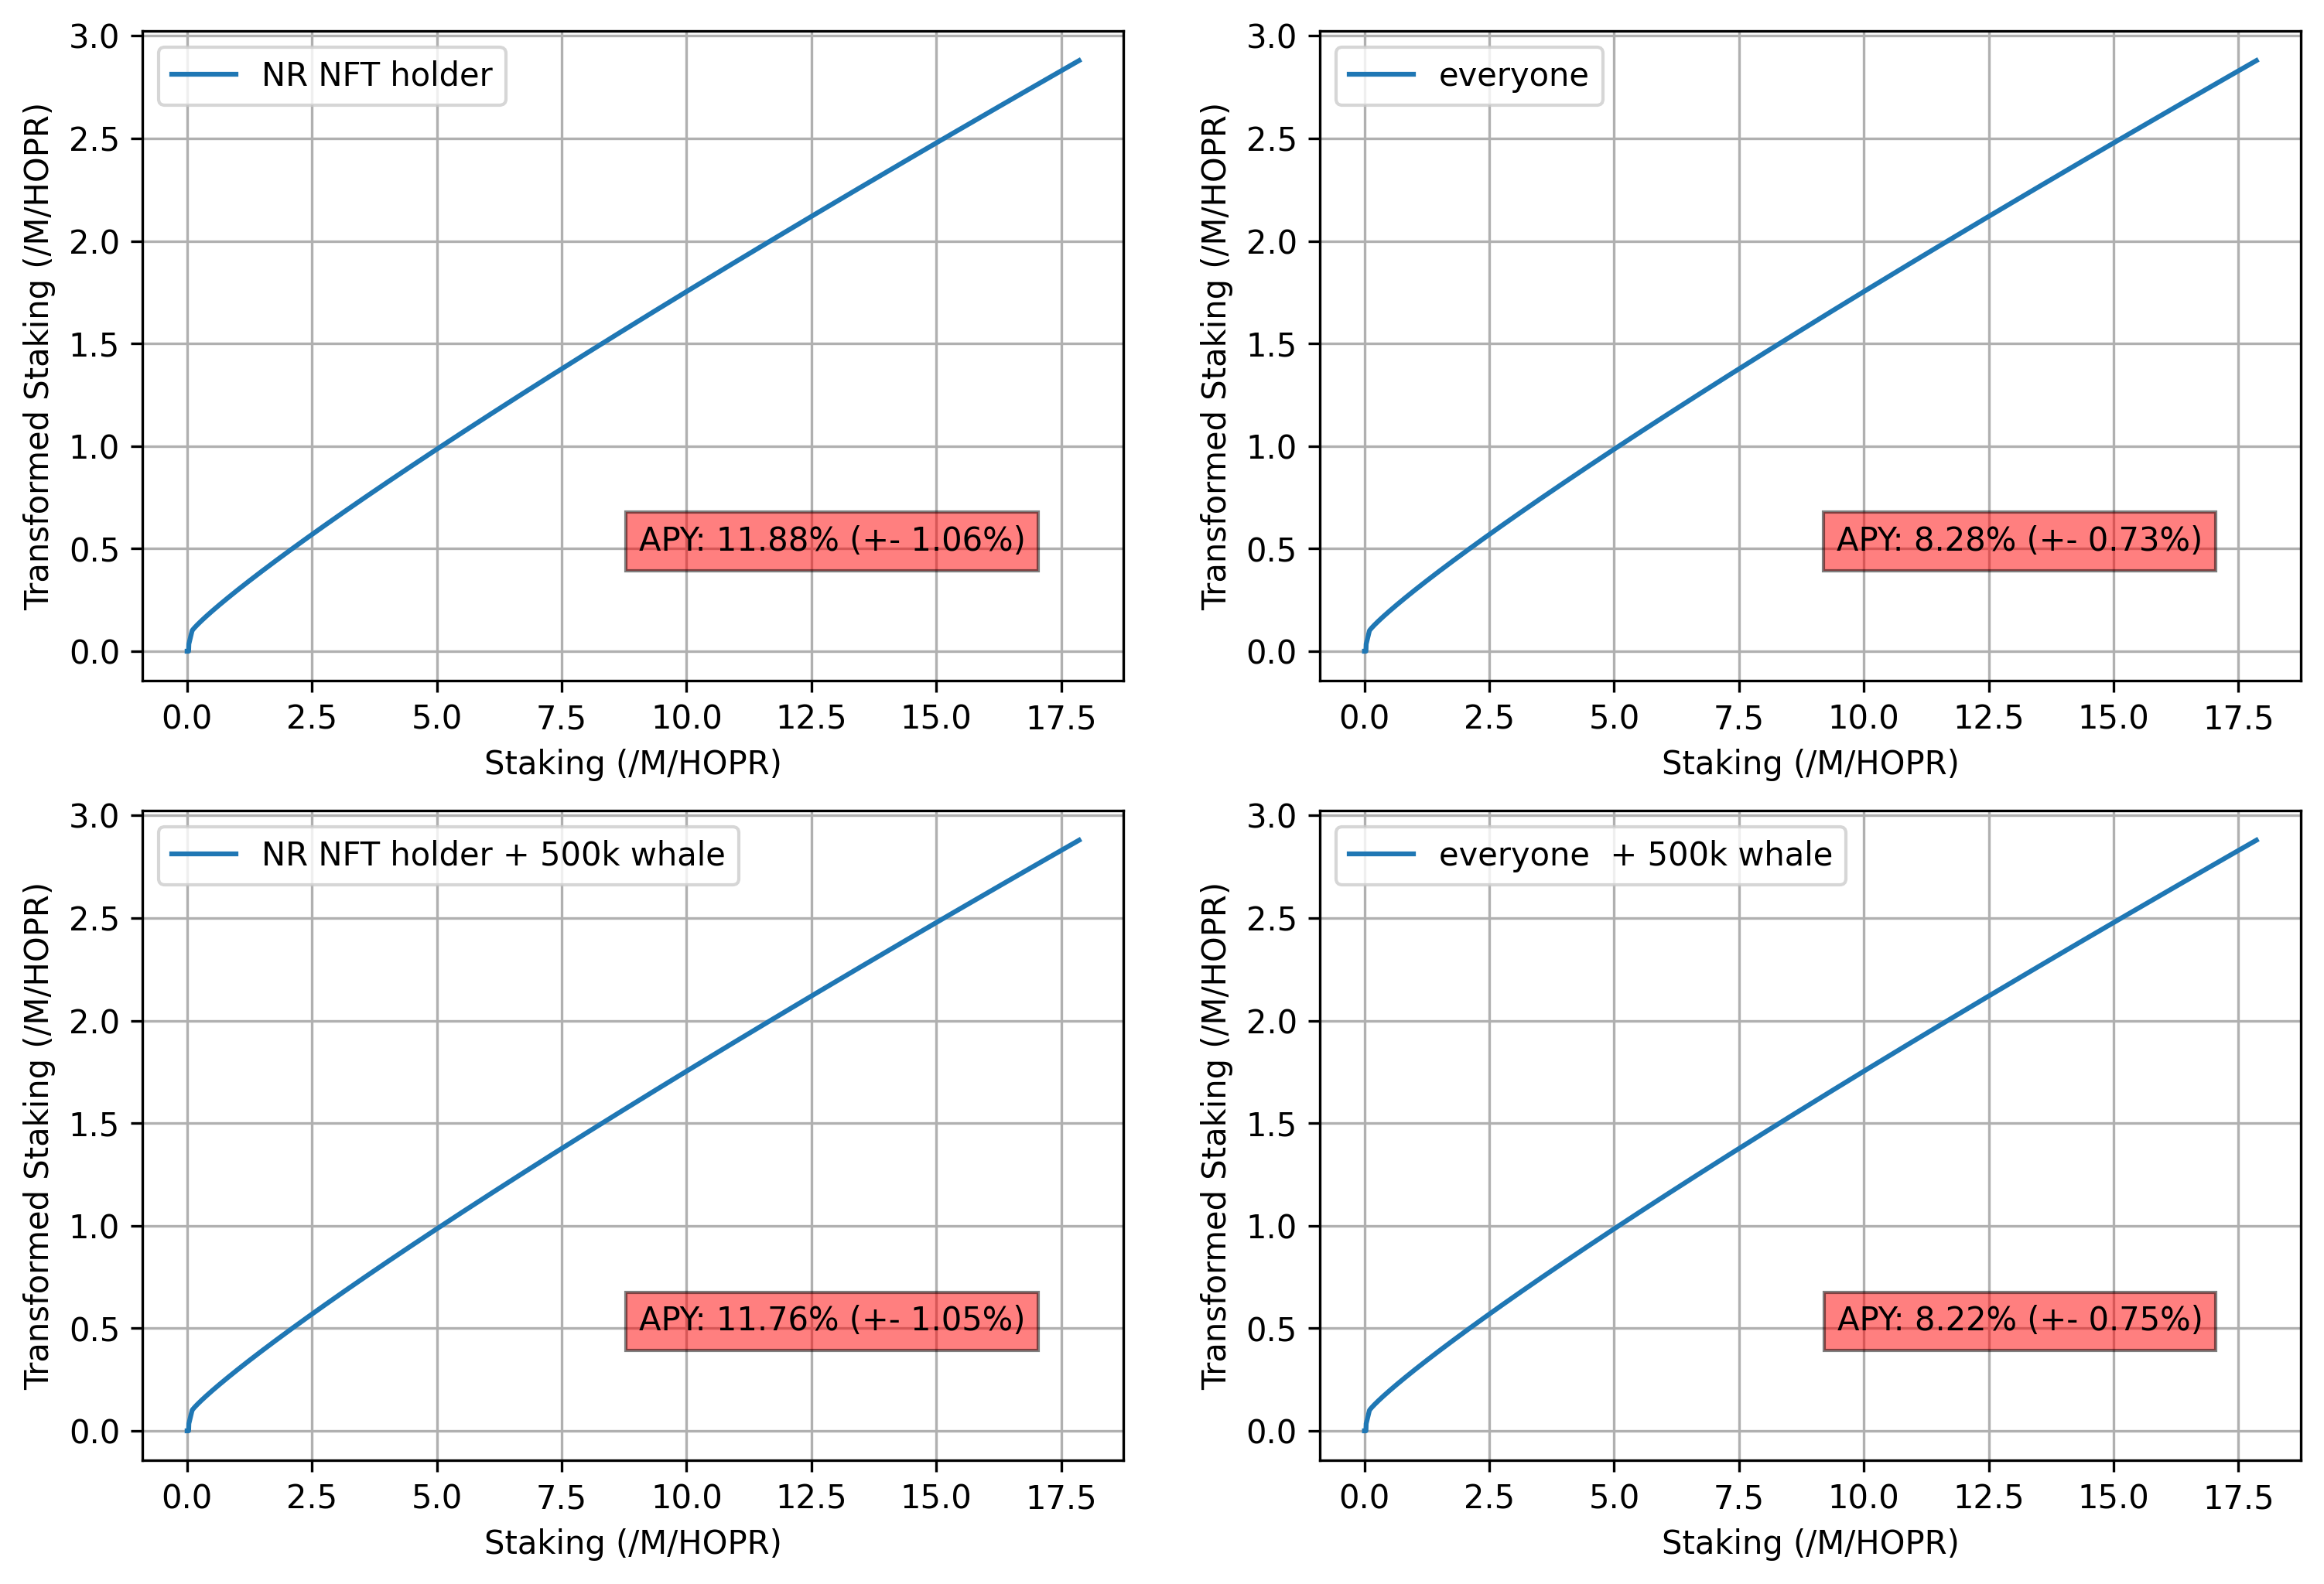

In [7]:
rows = 2
cols = int(len(options) / rows + 0.5)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*4), dpi=300)

axes = [axes] if isinstance(axes, Axes) else axes.flatten()

results = probabilistic_apy(datas, options, 200)

max_stakes = max([max(data) for data in datas])
stakes = range(0, int(max_stakes), 5000)
factor, prefix = factor_and_prefix(stakes[-1])

for opt, result, ax in zip(options, results, axes):
    tf_stakes = stake_transformation(stakes, **opt["model_arguments"])
    
    stakes_for_plt = [s/factor for s in stakes]
    tf_stakes_for_plt = [s/factor for s in tf_stakes]

    ax.plot(stakes_for_plt, tf_stakes_for_plt, label=opt["legend"])
    ax.set_xlabel(f"Staking (/{prefix}/HOPR)")
    ax.set_ylabel(f"Transformed Staking (/{prefix}/HOPR)")
    ax.text(0.9,
            0.2,
            f"APY: {result['average']:.2%} (+- {result['std']:.2%})",
            transform=ax.transAxes, 
            horizontalalignment='right', 
            bbox=dict(facecolor='red', alpha=0.5),)

    ax.legend()
    ax.grid()

plt.show()

In [11]:
model = 2
investment = 500_000
# 1 node

for node_count in range(1, 21, 2):
    tf_stake = stake_transformation([investment/node_count], **options[model]["model_arguments"])[0]
    reward = tf_stake * results[2]["average"] * node_count

    print(f"with {node_count:02d} node -> {reward:.02f} tokens")

with 01 node -> 22977.21 tokens
with 03 node -> 42119.95 tokens
with 05 node -> 58791.32 tokens
with 07 node -> 58791.32 tokens
with 09 node -> 58791.32 tokens
with 11 node -> 58791.32 tokens
with 13 node -> 58791.32 tokens
with 15 node -> 58791.32 tokens
with 17 node -> 0.00 tokens
with 19 node -> 0.00 tokens
